Dataset: .. _breast_cancer_dataset:
Features: 30
Classes: ['malignant' 'benign']

=== Manual Least Squares (1 feature) ===
              precision    recall  f1-score   support

   malignant       0.90      0.69      0.78        64
      benign       0.84      0.95      0.89       107

    accuracy                           0.85       171
   macro avg       0.87      0.82      0.83       171
weighted avg       0.86      0.85      0.85       171

Accuracy: 0.853801


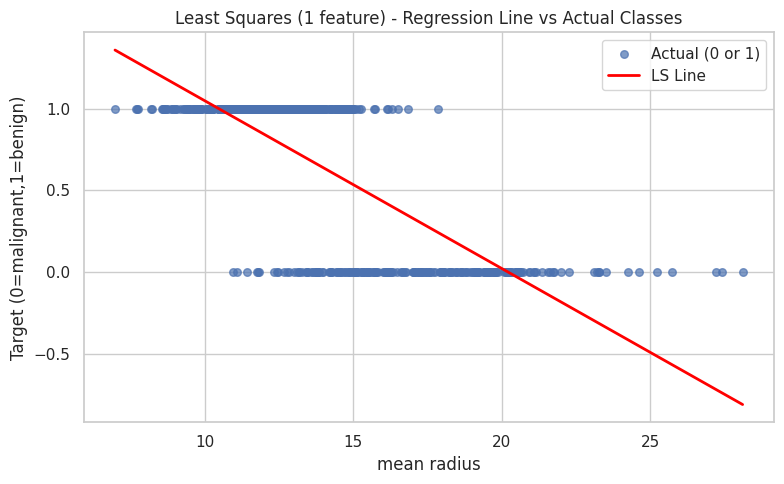

In [24]:
# mini_project_code.py
# Full mini-project code: LeastSquares (1 feature), Perceptron, SVM (GridSearch), PCA+Perceptron, Logistic
# Dataset: sklearn.datasets.load_breast_cancer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, RocCurveDisplay, confusion_matrix
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

# ---------- Config ----------
random_state = 42
test_size = 0.30  # 30% test like your sample

# ---------- Load dataset ----------
data = datasets.load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names  # ['malignant', 'benign']
print("Dataset:", data.DESCR.splitlines()[0])
print("Features:", feature_names.shape[0])
print("Classes:", target_names)

# ---------- Train/test split (stratified) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=random_state
)

# -------------------------
# 1) Manual Simple Linear Regression (Least Squares) on ONE feature
# -------------------------
# Choose a feature index (0 = mean radius). You can change it.
feat_idx = 0  # corresponds to 'mean radius'
X_single_train = X_train[:, feat_idx]
X_single_test = X_test[:, feat_idx]

# compute slope m and intercept c on TRAINING data (least squares)
X_mean = np.mean(X_single_train)
y_mean = np.mean(y_train.astype(float))
m = np.sum((X_single_train - X_mean) * (y_train - y_mean)) / np.sum((X_single_train - X_mean)**2)
c = y_mean - m * X_mean

# continuous predictions -> threshold at 0.5 to map to classes
y_pred_ls = (m * X_single_test + c >= 0.5).astype(int)
acc_ls = accuracy_score(y_test, y_pred_ls)
report_ls = classification_report(y_test, y_pred_ls, target_names=target_names)
print("\n=== Manual Least Squares (1 feature) ===")
print(report_ls)
print(f"Accuracy: {acc_ls:.6f}")

# Optional: plot regression line vs actual classes (all data)
X_single_all = X[:, feat_idx]
y_all = y
y_pred_all_cont = m * X_single_all + c
plt.figure(figsize=(8,5))
plt.scatter(X_single_all, y_all, label='Actual (0 or 1)', s=30, alpha=0.7)
order = np.argsort(X_single_all)
plt.plot(X_single_all[order], y_pred_all_cont[order], color='red', linewidth=2, label='LS Line')
plt.xlabel(feature_names[feat_idx])
plt.ylabel('Target (0=malignant,1=benign)')
plt.title('Least Squares (1 feature) - Regression Line vs Actual Classes')
plt.legend()
plt.tight_layout()
plt.show()


=== Perceptron (full features) ===
              precision    recall  f1-score   support

   malignant       0.98      0.97      0.98        64
      benign       0.98      0.99      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Accuracy: 0.982456


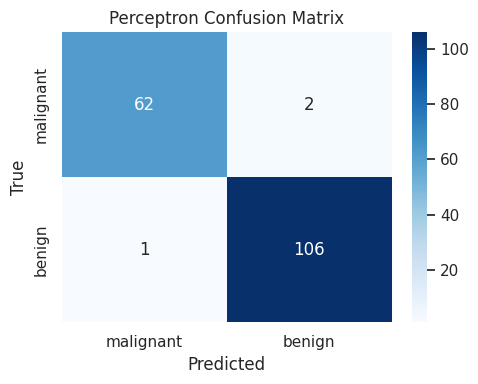

In [30]:
# -------------------------
# 2) Perceptron (full features)
# -------------------------
scaler_full = StandardScaler()
X_train_full = scaler_full.fit_transform(X_train)
X_test_full = scaler_full.transform(X_test)

perceptron_full = Perceptron(random_state=random_state, max_iter=2000, tol=1e-4)
perceptron_full.fit(X_train_full, y_train)
y_pred_perc = perceptron_full.predict(X_test_full)
acc_perc = accuracy_score(y_test, y_pred_perc)
report_perc = classification_report(y_test, y_pred_perc, target_names=target_names)
print("\n=== Perceptron (full features) ===")
print(report_perc)
print(f"Accuracy: {acc_perc:.6f}")

# Confusion matrix for Perceptron
cm_perc = confusion_matrix(y_test, y_pred_perc)
plt.figure(figsize=(5,4))
sns.heatmap(cm_perc, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title('Perceptron Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


=== SVM (full features) - GridSearch best params ===
Best params: {'C': 10, 'gamma': 0.01}
              precision    recall  f1-score   support

   malignant       0.97      0.98      0.98        64
      benign       0.99      0.98      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Accuracy: 0.982456

PCA(2) explained variance ratio: [0.44272026 0.18971182] sum: 0.6324320765155944
PCA(3) explained variance ratios: [0.44272026 0.18971182 0.09393163]


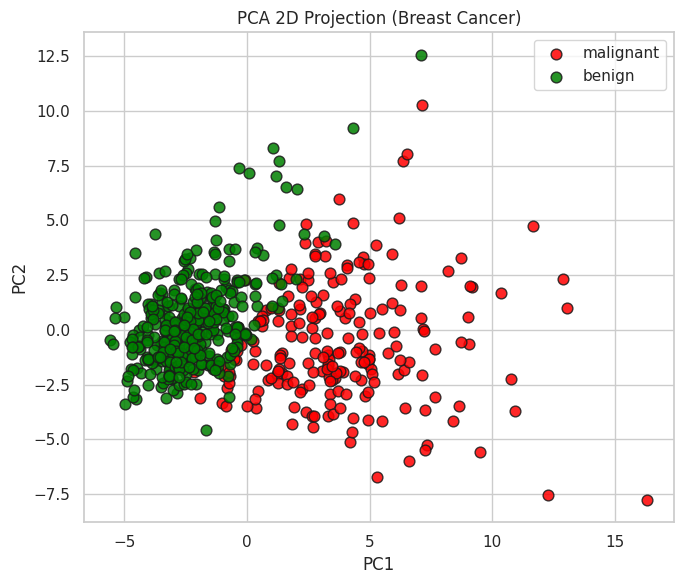

In [31]:
# -------------------------
# 3) SVM (full features) + GridSearchCV
# -------------------------
svm = SVC(kernel='rbf', probability=True, random_state=random_state)
param_grid = {'C': [0.1, 1, 10, 50], 'gamma': ['scale', 0.01, 0.1, 1]}
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_full, y_train)
best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_full)
acc_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, target_names=target_names)
print("\n=== SVM (full features) - GridSearch best params ===")
print("Best params:", grid.best_params_)
print(report_svm)
print(f"Accuracy: {acc_svm:.6f}")

# -------------------------
# 4) PCA -> Perceptron (top-2 PCs) + PCA 2D/3D visualizations
# -------------------------
scaler_for_pca = StandardScaler()
X_scaled = scaler_for_pca.fit_transform(X)  # whole dataset scaled for PCA

pca2 = PCA(n_components=2, random_state=random_state)
X_pca_2d = pca2.fit_transform(X_scaled)
explained_ratio_2 = pca2.explained_variance_ratio_
print("\nPCA(2) explained variance ratio:", explained_ratio_2, "sum:", explained_ratio_2.sum())

pca3 = PCA(n_components=3, random_state=random_state)
X_pca_3d = pca3.fit_transform(X_scaled)
print("PCA(3) explained variance ratios:", pca3.explained_variance_ratio_)

# 2D PCA scatter
plt.figure(figsize=(7,6))
colors = ['red', 'green']
labels = [target_names[0], target_names[1]]
for color, i, label in zip(colors, [0,1], labels):
    plt.scatter(X_pca_2d[y==i,0], X_pca_2d[y==i,1], color=color, label=label, s=60, alpha=0.85, edgecolors='k')
plt.title("PCA 2D Projection (Breast Cancer)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

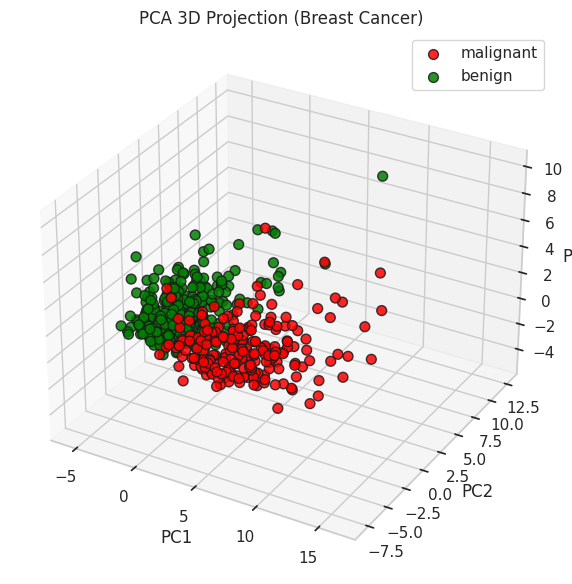

In [32]:
# 3D PCA scatter
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for color, i, label in zip(colors, [0,1], labels):
    ax.scatter(X_pca_3d[y==i,0], X_pca_3d[y==i,1], X_pca_3d[y==i,2], color=color, label=label, s=50, alpha=0.85, edgecolors='k')
ax.set_title("PCA 3D Projection (Breast Cancer)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()


=== Perceptron on PCA(2) features ===
              precision    recall  f1-score   support

   malignant       0.90      0.94      0.92        64
      benign       0.96      0.93      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Accuracy: 0.935673

=== Logistic Regression (full features) ===
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Accuracy: 0.988304


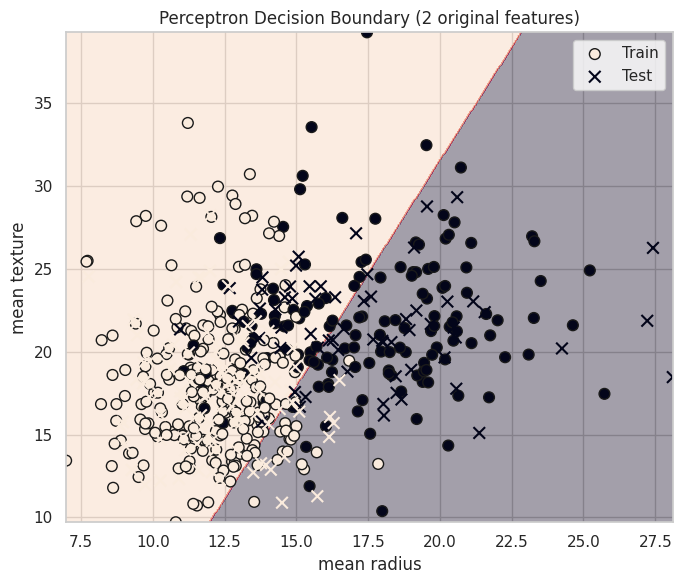

In [33]:
# Train Perceptron on top-2 PCA components (split with same stratify)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca_2d, y, test_size=test_size, stratify=y, random_state=random_state
)
scaler_pca = StandardScaler()
X_pca_train_s = scaler_pca.fit_transform(X_pca_train)
X_pca_test_s = scaler_pca.transform(X_pca_test)

perc_pca = Perceptron(random_state=random_state, max_iter=2000, tol=1e-4)
perc_pca.fit(X_pca_train_s, y_pca_train)
y_pred_pca = perc_pca.predict(X_pca_test_s)
acc_pca = accuracy_score(y_pca_test, y_pred_pca)
report_pca = classification_report(y_pca_test, y_pred_pca, target_names=target_names)
print("\n=== Perceptron on PCA(2) features ===")
print(report_pca)
print(f"Accuracy: {acc_pca:.6f}")

# -------------------------
# 5) Logistic Regression baseline (full features)
# -------------------------
logreg = LogisticRegression(max_iter=5000, random_state=random_state)
logreg.fit(X_train_full, y_train)
y_pred_log = logreg.predict(X_test_full)
acc_log = accuracy_score(y_test, y_pred_log)
report_log = classification_report(y_test, y_pred_log, target_names=target_names)
print("\n=== Logistic Regression (full features) ===")
print(report_log)
print(f"Accuracy: {acc_log:.6f}")

# -------------------------
# Decision boundary visualizations (2-feature projection = first two original features)
# -------------------------
vis_idx = [0,1]  # choose first two original features (change if desired)
X_vis = X[:, vis_idx]
X_vis_train, X_vis_test, y_vis_train, y_vis_test = train_test_split(
    X_vis, y, test_size=test_size, stratify=y, random_state=random_state
)
scaler_vis = StandardScaler()
X_vis_train_s = scaler_vis.fit_transform(X_vis_train)
X_vis_test_s = scaler_vis.transform(X_vis_test)

# Perceptron for visualization
perc_vis = Perceptron(random_state=random_state, max_iter=2000, tol=1e-4)
perc_vis.fit(X_vis_train_s, y_vis_train)

# SVM linear for visualization
svm_vis = SVC(kernel='linear', C=1.0, random_state=random_state)
svm_vis.fit(X_vis_train_s, y_vis_train)

# Create mesh grid using original (not scaled) domain but transform before predict
x_min, x_max = X_vis[:,0].min(), X_vis[:,0].max()
y_min, y_max = X_vis[:,1].min(), X_vis[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
mesh_grid = np.c_[xx.ravel(), yy.ravel()]
mesh_grid_s = scaler_vis.transform(mesh_grid)

# Perceptron decision map
Zp = perc_vis.predict(mesh_grid_s).reshape(xx.shape)
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Zp, alpha=0.4)
plt.scatter(X_vis_train[:,0], X_vis_train[:,1], c=y_vis_train, edgecolors='k', s=60, label='Train')
plt.scatter(X_vis_test[:,0], X_vis_test[:,1], c=y_vis_test, marker='x', s=70, label='Test')
plt.title('Perceptron Decision Boundary (2 original features)')
plt.xlabel(feature_names[vis_idx[0]])
plt.ylabel(feature_names[vis_idx[1]])
plt.legend()
plt.tight_layout()
plt.show()

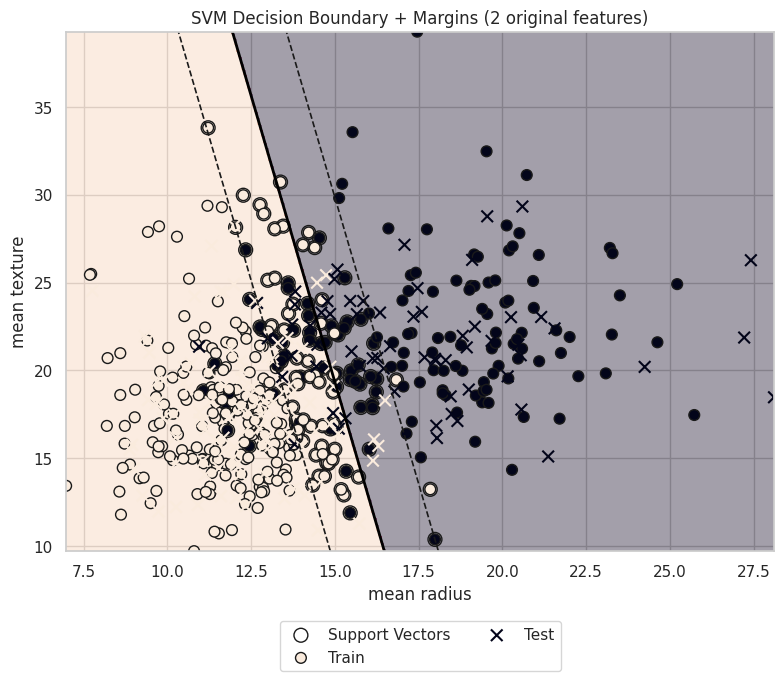

In [34]:
# SVM decision boundary + margins + support vectors
Zs = svm_vis.decision_function(mesh_grid_s).reshape(xx.shape)
Zs_class = (Zs >= 0).astype(int)
plt.figure(figsize=(8,7))
plt.contourf(xx, yy, Zs_class, alpha=0.4)
# boundary and margins
plt.contour(xx, yy, Zs, levels=[0.0], linewidths=2, colors='black')
plt.contour(xx, yy, Zs, levels=[-1.0, 1.0], linestyles='--', linewidths=1.2, colors='k')
# support vectors (in scaled space -> original)
sv_orig = scaler_vis.inverse_transform(svm_vis.support_vectors_)
plt.scatter(sv_orig[:,0], sv_orig[:,1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')
plt.scatter(X_vis_train[:,0], X_vis_train[:,1], c=y_vis_train, edgecolors='k', s=60, label='Train')
plt.scatter(X_vis_test[:,0], X_vis_test[:,1], c=y_vis_test, marker='x', s=70, label='Test')
plt.title('SVM Decision Boundary + Margins (2 original features)')
plt.xlabel(feature_names[vis_idx[0]])
plt.ylabel(feature_names[vis_idx[1]])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.tight_layout()
plt.show()


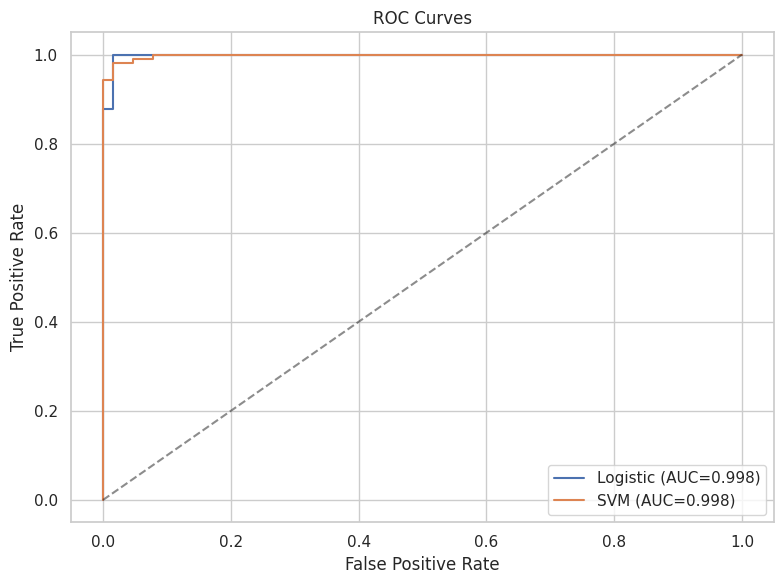

In [36]:
# -------------------------
# ROC Curves for models that provide probabilities (SVM(prob=True), Logistic)
# -------------------------
plt.figure(figsize=(8,6))
# Logistic
y_score_log = logreg.predict_proba(X_test_full)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={auc_log:.3f})')

# SVM (probabilities)
y_score_svm = best_svm.predict_proba(X_test_full)[:,1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={auc_svm:.3f})')

# Perceptron (no prob) - skip
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()


=== Accuracy Summary ===
         Model  Accuracy
  LeastSquares  0.853801
    Perceptron  0.982456
           SVM  0.982456
PCA-Perceptron  0.935673
      Logistic  0.988304


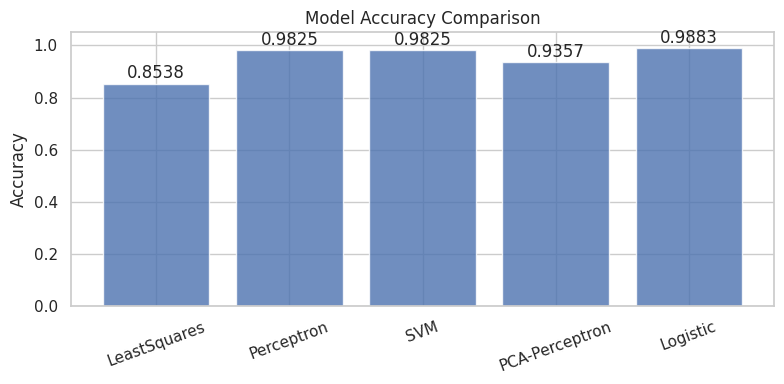

In [37]:
# -------------------------
# Final accuracy comparison table & bar chart
# -------------------------
models = ['LeastSquares', 'Perceptron', 'SVM', 'PCA-Perceptron', 'Logistic']
accuracies = [acc_ls, acc_perc, acc_svm, acc_pca, acc_log]

summary_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
print("\n=== Accuracy Summary ===")
print(summary_df.to_string(index=False))

plt.figure(figsize=(8,4))
bars = plt.bar(summary_df['Model'], summary_df['Accuracy'], alpha=0.8)
plt.ylim(0,1.05)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, f"{acc:.4f}", ha='center')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Optionally save summary to CSV
# summary_df.to_csv('model_accuracy_summary.csv', index=False)

# -------------------------
# End of script
# -------------------------
